# YOLO Object Detection and Tracking: Model Comparison

## Comparing Inference Speed of YOLOv10n, YOLOv11n, and YOLOv12n

This notebook compares the inference speeds of three YOLO models (YOLOv10n, YOLOv11n, and YOLOv12n) on an object tracking task using the same input video.


## 1. Environment Setup

First, let's install the required packages and import necessary libraries.

In [1]:
# Install required packages
!pip install ultralytics opencv-python pandas matplotlib seaborn ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

In [2]:
# Import libraries
import os
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
from IPython.display import display, HTML, Image
import torch

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cpu


## 2. Loading YOLO Models

Let's load all three YOLO model versions with consistent parameters for fair comparison.

In [10]:
# Function to load models
def load_model(model_name):
    try:
        model = YOLO(model_name)
        print(f"Successfully loaded {model_name}")
        return model
    except Exception as e:
        print(f"Error loading {model_name}: {e}")
        return None

# Load the three model versions
models = {
    'YOLOv10n': load_model('yolov10n.pt'),
    'YOLOv11n': load_model('yolo11n.pt'),
    'YOLOv12n': load_model('yolo12n.pt')
}

Successfully loaded yolov10n.pt


100%|██████████| 5.35M/5.35M [00:00<00:00, 62.3MB/s]

Successfully loaded yolo11n.pt



100%|██████████| 5.34M/5.34M [00:00<00:00, 59.6MB/s]


Successfully loaded yolo12n.pt


## 3. Setting Parameters

Configure consistent parameters for all models to ensure fair comparison.

In [11]:
# Common parameters for all models
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.45
INPUT_WIDTH = 640  # Standard input width for YOLO nano models
INPUT_HEIGHT = 640  # Standard input height for YOLO nano models

# Specify the input video path
video_path = "test1.mp4"

# Create output directory if it doesn't exist
output_dir = "output_videos"
os.makedirs(output_dir, exist_ok=True)

## 4. Object Tracking Function

Define a function to process the video with each model and measure inference speed.

In [12]:
def process_video(model, model_name, video_path, save_output=True):
    """
    Process a video with the given YOLO model and track objects.
    Measure and return inference speed metrics.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Prepare output video writer if save_output is True
    if save_output:
        output_path = f"{output_dir}/{model_name}_tracked.mp4"
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Initialize tracking metrics
    frame_times = []
    processed_frames = 0

    # Process each frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Measure inference time
        start_time = time.time()

        # Run detection and tracking
        results = model.track(frame, persist=True, conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD)

        # Calculate inference time
        end_time = time.time()
        inference_time = (end_time - start_time) * 1000  # convert to ms
        frame_times.append(inference_time)

        # Draw results on frame
        annotated_frame = results[0].plot()

        # Add inference time text to frame
        cv2.putText(annotated_frame, f"{model_name}: {inference_time:.2f} ms",
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Write frame to output video
        if save_output:
            out.write(annotated_frame)

        processed_frames += 1

        # Print progress every 10 frames
        if processed_frames % 10 == 0:
            print(f"{model_name}: Processed {processed_frames}/{frame_count} frames")

    # Release resources
    cap.release()
    if save_output:
        out.release()

    # Calculate metrics
    avg_inference_time = np.mean(frame_times)
    fps = 1000 / avg_inference_time  # Convert ms to FPS

    metrics = {
        'model': model_name,
        'avg_inference_time_ms': avg_inference_time,
        'fps': fps,
        'total_frames': processed_frames,
        'output_path': f"{output_dir}/{model_name}_tracked.mp4" if save_output else None
    }

    return metrics

## 5. Process Video with Each Model

Now let's process the video with each model and collect performance metrics.

In [13]:
# Check if the video file exists
if not os.path.exists(video_path):
    print(f"Error: Video file {video_path} not found.")
    print("Please upload a video file and update the 'video_path' variable.")
else:
    # Process video with each model
    results = []
    for model_name, model in models.items():
        if model is not None:
            print(f"\nProcessing video with {model_name}...")
            metrics = process_video(model, model_name, video_path)
            if metrics:
                results.append(metrics)
                print(f"Completed {model_name} processing.")
                print(f"Average inference time: {metrics['avg_inference_time_ms']:.2f} ms")
                print(f"Average FPS: {metrics['fps']:.2f}")
            else:
                print(f"Failed to process video with {model_name}")

Streaming output truncated to the last 5000 lines.
Speed: 3.3ms preprocess, 155.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 153.4ms
Speed: 3.6ms preprocess, 153.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 147.9ms
Speed: 4.2ms preprocess, 147.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 149.7ms
Speed: 3.0ms preprocess, 149.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 170.2ms
Speed: 3.3ms preprocess, 170.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 145.7ms
Speed: 3.0ms preprocess, 145.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 153.1ms
Speed: 3.2ms preprocess, 153.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
YOLOv11n: Processed 280/942 frames

0: 38

## 6. Compare Results

Let's create comparison tables and visualizations for the inference speeds.

Inference Speed Comparison:


,model,avg_inference_time_ms,fps
0,YOLOv10n,207.901408,4.809972
1,YOLOv11n,217.757813,4.592258
2,YOLOv12n,239.739370,4.171196


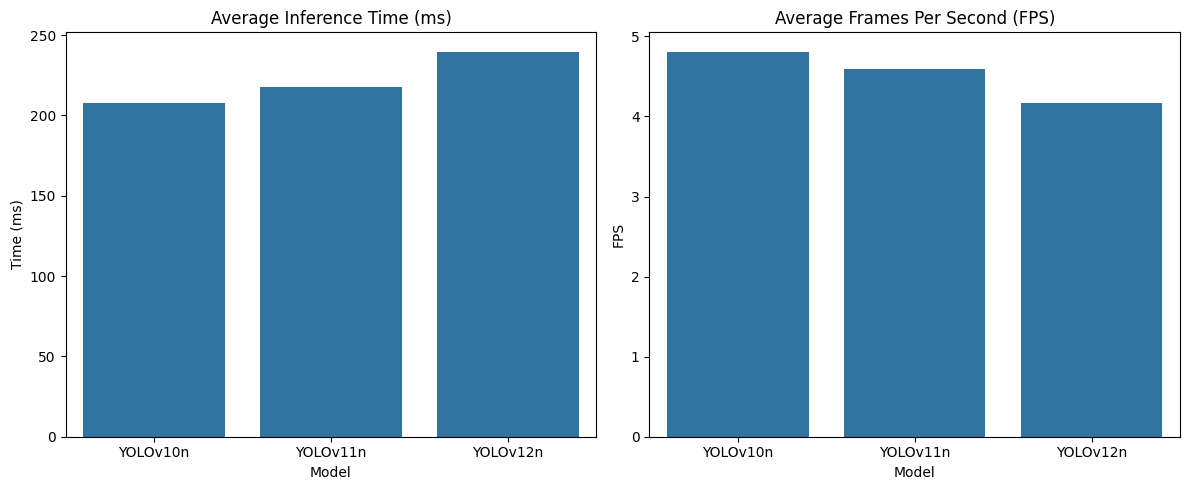

In [14]:
# Create a DataFrame for easy comparison
if results:
    df_results = pd.DataFrame(results)
    # Display the results table
    print("Inference Speed Comparison:")
    display(df_results[['model', 'avg_inference_time_ms', 'fps']])

    # Create bar charts to visualize the comparison
    plt.figure(figsize=(12, 5))

    # Plot inference time comparison
    plt.subplot(1, 2, 1)
    sns.barplot(x='model', y='avg_inference_time_ms', data=df_results)
    plt.title('Average Inference Time (ms)')
    plt.ylabel('Time (ms)')
    plt.xlabel('Model')

    # Plot FPS comparison
    plt.subplot(1, 2, 2)
    sns.barplot(x='model', y='fps', data=df_results)
    plt.title('Average Frames Per Second (FPS)')
    plt.ylabel('FPS')
    plt.xlabel('Model')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/inference_speed_comparison.png")
    plt.show()
else:
    print("No results to compare.")

## 7. Display Sample Frames from Each Output Video

Let's extract and display sample frames from each processed video to visually compare the results.

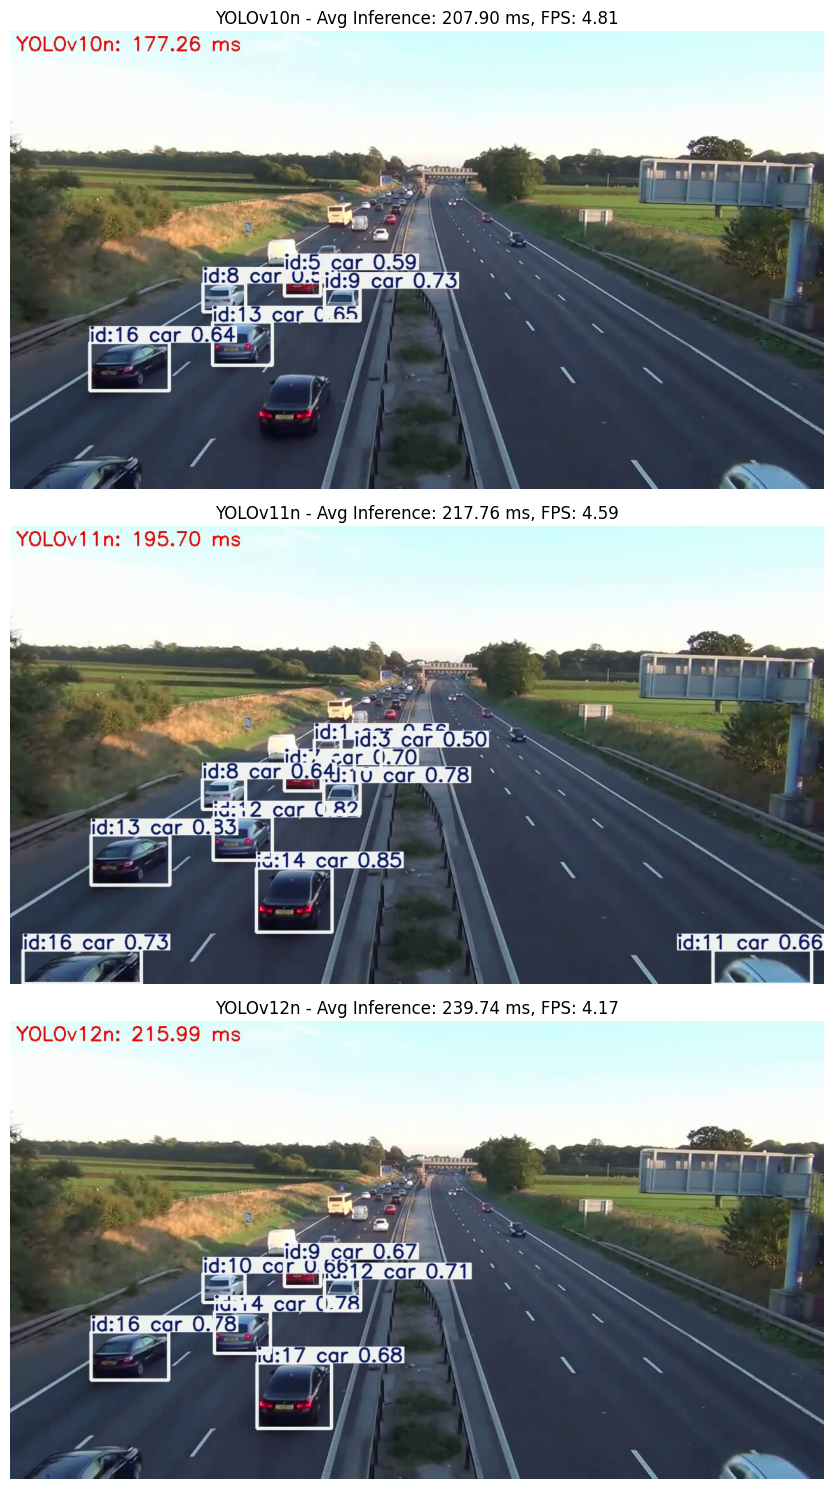

In [15]:
def extract_frame(video_path, frame_number=100):
    """Extract a specific frame from a video file"""
    if not os.path.exists(video_path):
        print(f"Video file {video_path} not found")
        return None

    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        print(f"Could not extract frame {frame_number} from {video_path}")
        return None

# Display sample frames
plt.figure(figsize=(15, 5*len(results)))
for i, result in enumerate(results):
    if 'output_path' in result and result['output_path'] and os.path.exists(result['output_path']):
        frame = extract_frame(result['output_path'])
        if frame is not None:
            plt.subplot(len(results), 1, i+1)
            plt.imshow(frame)
            plt.title(f"{result['model']} - Avg Inference: {result['avg_inference_time_ms']:.2f} ms, FPS: {result['fps']:.2f}")
            plt.axis('off')

plt.tight_layout()
plt.savefig(f"{output_dir}/model_comparison_frames.png")
plt.show()

## 8. Conclusion and Analysis

Let's analyze the results and draw conclusions about the performance of each model.

In [16]:
if results:
    # Sort models by speed (FPS)
    sorted_results = sorted(results, key=lambda x: x['fps'], reverse=True)

    # Identify fastest and slowest models
    fastest = sorted_results[0]
    slowest = sorted_results[-1]

    # Calculate speed difference
    speed_diff_percent = ((fastest['fps'] - slowest['fps']) / slowest['fps']) * 100

    print("\nPerformance Analysis:")
    print(f"Fastest model: {fastest['model']} with {fastest['fps']:.2f} FPS ({fastest['avg_inference_time_ms']:.2f} ms per frame)")
    print(f"Slowest model: {slowest['model']} with {slowest['fps']:.2f} FPS ({slowest['avg_inference_time_ms']:.2f} ms per frame)")
    print(f"The fastest model is approximately {speed_diff_percent:.1f}% faster than the slowest model.")


Performance Analysis:
Fastest model: YOLOv10n with 4.81 FPS (207.90 ms per frame)
Slowest model: YOLOv12n with 4.17 FPS (239.74 ms per frame)
The fastest model is approximately 15.3% faster than the slowest model.
